This is a really simple check of the underlying demographics of the clusters detected. For the time being, all I'm going to do is draw a circle 1 mile (5,280 ft) around each centroid, and check that the % of each race across all clusters is equal to the % of each race in the population at large. Since we are storing the list of points assigned to each center as a separate file where the first row contains the centroid coordinates, we need to loop through all the files, extract the centroid, and compare all points to the 5,280 ft threshold. Those that fall within that threshold will be extracted into a new dataset that will be used to look at the aggregate proportions.

In [326]:
import pandas as pd
from geopy.distance import lonlat
import math
import os
import shapefile as shp
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from ipynb.fs.full.demog_functions import plot_shape, plot_map
#from ipynb.fs.full.demog_functions import calc_euclidean

In [144]:
def calc_euclidean(x,y,x_ref,y_ref):
    distance = math.sqrt(((x-x_ref)**2)+(y-y_ref)**2)
    return distance

In [158]:
# start by finding the population-level proportions for each race
data = pd.read_csv('PseudoSynthDemogData.csv')
pop_race_count = data['race'].value_counts()
total_pop = len(data)
percent_race = pop_race_count / total_pop
del(data)

In [159]:
percent_race

white       0.427777
black       0.243165
other       0.151225
asian       0.139991
two_plus    0.033305
native      0.004029
hawaiian    0.000509
Name: race, dtype: float64

In [196]:
# want to look for points within the following distance from the centroid
d = 5280/4
    
# initiate tickers for each race
white = 0
black = 0
asian = 0
other = 0
two_plus = 0
native = 0
hawaiian = 0

# also going to collect the x- and y- coordinates of covered points to visualize and check them
x_coords = []
y_coords = []

# ...as well as the corresponding cendroids
x_center = []
y_center = []
    
path = 'kmeans_centroids/k_100_membership/'

for i in os.listdir(path):
       
    data = pd.read_csv(path+i,skiprows=1,names=['race','x','y'],dtype={'race':np.str,'x':np.float64,'y':np.float64})

    # extract centroid info
    tot_clus_count = data.columns[0]
    x_ref = float(data.columns[1]) #can take out the float
    y_ref = float(data.columns[2])
    
    x_center.append(x_ref)
    y_center.append(y_ref)

    # pull out the points that are within some distance from the centroid
        
    i=0
    points = []

    while i < len(data):
        x = data['x'][i]
        y = data['y'][i]
        race = data['race'][i]

        if calc_euclidean(x,y,x_ref,y_ref) <= d:
            points.append(race)
            x_coords.append(x)
            y_coords.append(y)
        i+=1

    white = white + points.count('white')
    black = black + points.count('black')
    asian = asian + points.count('asian')
    other = other + points.count('other')
    two_plus = two_plus + points.count('two_plus')
    native = native + points.count('native')
    hawaiian = hawaiian + points.count('hawaiian')
        
    del(data)

In [197]:
total_cluster = white + black + asian + other + two_plus + native + hawaiian
total_cluster

838974

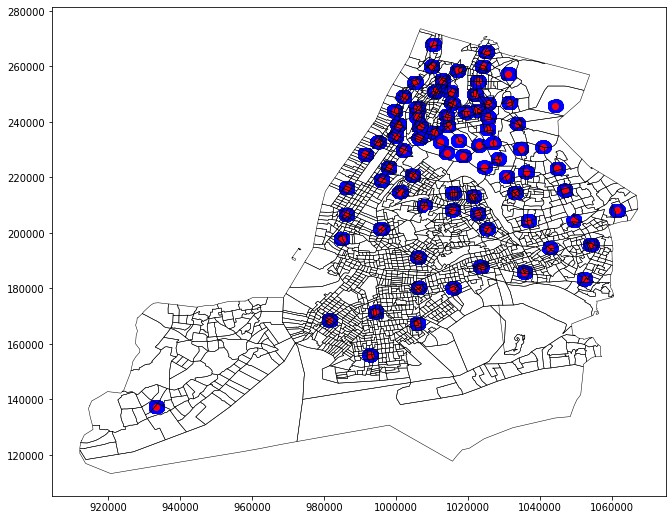

In [198]:
# to double check that the procedure above is working as we expect, I'll plot the coordinates and centroids.
# connect to shapefile
# 'sf' refers to the extracted shape data
shp_path = 'nyu_2451_34513/nyu_2451_34513.shp' 
sf = shp.Reader(shp_path)

# plot out
plot_map(sf)
plt.scatter(x_coords,y_coords,color='b')
plt.scatter(x_center,y_center,color='r')

In [199]:
# now calculate the % of each race that is covered by the clusters
perc_white = white / total_cluster
perc_black = black / total_cluster
perc_asian = asian / total_cluster
perc_other = other /total_cluster
perc_two_plus = two_plus / total_cluster
perc_native = native / total_cluster
perc_hawaiian = hawaiian / total_cluster

In [200]:
# want to plot the difference between the population-level and cluster-level proportions for each race
race_rates = pd.DataFrame({'race':['white','black','asian','other','two_plus','native','hawaiian'],
              'population_level':[percent_race[0],percent_race[1],percent_race[3],percent_race[2],percent_race[4],percent_race[5],percent_race[6]],
                           'cluster_level':[perc_white,perc_black,perc_asian,perc_other,perc_two_plus,perc_native,perc_hawaiian]})
race_rates

,race,population_level,cluster_level
0,white,0.427777,0.328852
1,black,0.243165,0.243078
2,asian,0.139991,0.124341
3,other,0.151225,0.258212
4,two_plus,0.033305,0.039821
5,native,0.004029,0.004947
6,hawaiian,0.000509,0.000750


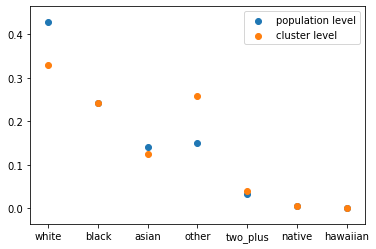

In [202]:
plt.scatter(race_rates['race'],race_rates['population_level'],label='population level')
plt.scatter(race_rates['race'],race_rates['cluster_level'],label = 'cluster level')
plt.legend()

In [266]:
# calculate cumulative density function for each of the races
# just pulling out the distances for points < d distance from the centroid.
d = 5280/4
path = 'kmeans_centroids/k_100_membership/'

cdf_race = []
cdf_distance = []

for i in os.listdir(path):     
    data = pd.read_csv(path+i,skiprows=1,names=['race','x','y'],dtype={'race':np.str,'x':np.float64,'y':np.float64})
    
    # extract centroid info
    ref = pd.read_csv(path+i,header=None, nrows=1,names=['total','xc','yc'])
    x_ref = ref['xc'][0]
    y_ref = ref['yc'][0]
    
    # pull out the points that are within some distance from the centroid
        
    i=0
    while i < len(data):
        x = data['x'][i]
        y = data['y'][i]
        race = data['race'][i]

        if calc_euclidean(x,y,x_ref,y_ref) <= d:
            distance = calc_euclidean(x,y,x_ref,y_ref)
            cdf_race.append(race)
            cdf_distance.append(distance)
        i+=1
    
    del(data)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Distance from centroid - CDF stratified by race')

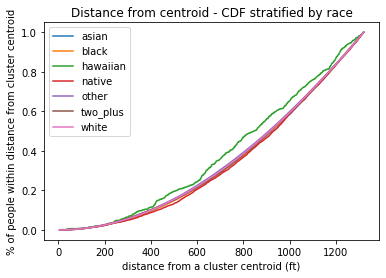

In [347]:
# I think something might be wrong with this 

num_bins = 1000

n=len(np.unique(cdf_race))
color=iter(cm.rainbow(np.linspace(0,1,n)))

for r in np.unique(cdf_race):
    
    race_index = []
    for i in range(len(cdf_race)):
        if cdf_race[i]==r:
            race_index.append(i)
    
    r_dist = [cdf_distance[i] for i in race_index]
    
    counts, bin_edges = np.histogram (r_dist, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1],label=r)
plt.legend()
plt.xlabel('distance from a cluster centroid (ft)')
plt.ylabel('% of people within distance from cluster centroid')
plt.title('Distance from centroid - CDF stratified by race')